### Project Aim (Pedestrian data from tweets)

Find which sidewalk, pathway is problematic or not walkable and map it. Project aim is to build a sentiment analysis model with given training dataset, so that it can be applied to tweets gathered through twitter api. Once the model is built, tweets from Calgary gathered will be used for sentimenet analysis and NER (if helpful) .

Feature engineering:
maximum features - experiment with maximum number of features to see how the results differ.
n-grams - experiment with different n-grams (unigram, unigram+bigram, bigram only, etc.)
stemming/lemmatizing - test both with and without stemming or lemmatization
vectorizing - test different vectorizing models (count vectorizer, tfidf vectorizer, word2vec/doc2vec)
lexicon - test with and without lexicon use, think of good way to use lexicon feature with the model

Models:
try different models with above features.
Logistic Regression, Random Forest, Naive Bayes,etc.
And also try simple neural network to compare the performance

Risks:
By relying on training data's vocabularies, if the training data is not big enough,
it has a risk of performing not very well with new data,
in this case, new tweets which will be gathered through twitter api

In [139]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
cols = ['sentiment','id','date','query','user','text'] #
sentiment_analysis_train= pd.read_csv('training.1600000.processed.noemoticon.csv',header=None, names=cols, nrows=200000)
# above line will be different depending on where you saved your data, and your file name
# drop columns which are not necessary
sentiment_analysis_train.drop(['id','date','query','user'],axis=1,inplace=True)
sentiment_analysis_train.iloc[sentiment_analysis_train[sentiment_analysis_train.isnull().any(axis=1)].index,:].head()
sentiment_analysis_train.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


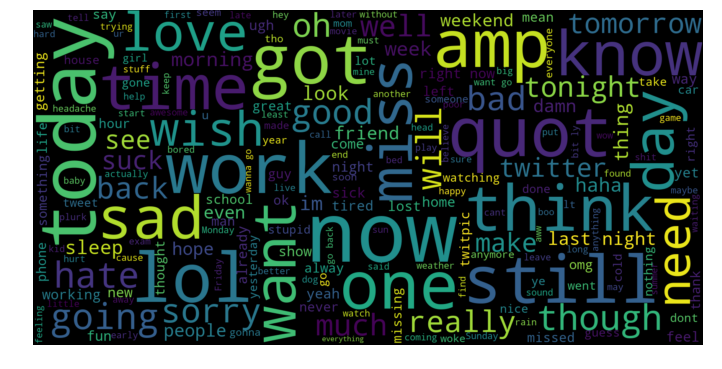

In [145]:
neg_tweets = sentiment_analysis_train[sentiment_analysis_train.sentiment == 0]
neg_string = []
for t in neg_tweets.text:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [152]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer()
cvec.fit(sentiment_analysis_train.text)
len(cvec.get_feature_names())

134852

Count vectorizer has extracted 134852 words out of the corpus.

In [153]:
neg_doc_matrix = cvec.transform(sentiment_analysis_train[sentiment_analysis_train.sentiment == 0].text)
pos_doc_matrix = cvec.transform(sentiment_analysis_train[sentiment_analysis_train.sentiment == 1].text)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()


In [155]:
document_matrix = cvec.transform(sentiment_analysis_train.text)

In [91]:
# Import the necessary modules
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import sent_tokenize
from nltk import pos_tag, word_tokenize, ne_chunk_sents, sent_tokenize
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from bs4 import BeautifulSoup
import re

In [70]:
ped_data=pd.read_csv('ped_data.csv', header=0)

In [95]:
ped_data['pre_clean_len'] = [len(t) for t in ped_data.tweet]
ped_data['clean_tweet'] = [len(t) for t in ped_data.tweet]

In [88]:
ped_data.head()

,Unnamed: 0,Date,tweet,pre_clean_len
0,0,2018-10-06 14:44:03,@askarlene Thank you for bringing this to our ...,128
1,1,2018-10-06 14:44:03,@askarlene Thank you for bringing this to our ...,128
2,2,2018-10-05 16:50:26,@WilluMilkit Hi James - snow route signs are o...,140
3,3,2018-10-05 14:30:52,The snow route parking ban has been lifted as ...,136
4,4,2018-10-04 20:15:32,UPDATE: The snow route parking ban will be lif...,132


In [112]:
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))

def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    lower_case = letters_only.lower()
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()
testing = ped_data.tweet

test_result = []
for t in testing:
    test_result.append(tweet_cleaner(t))
ped_data['clean_tweet'] = test_result

In [113]:
ped_data.head()

,Unnamed: 0,Date,tweet,pre_clean_len,clean_tweet
0,0,2018-10-06 14:44:03,@askarlene Thank you for bringing this to our ...,128,thank you for bringing this to our attention w...
1,1,2018-10-06 14:44:03,@askarlene Thank you for bringing this to our ...,128,thank you for bringing this to our attention w...
2,2,2018-10-05 16:50:26,@WilluMilkit Hi James - snow route signs are o...,140,hi james snow route signs are only posted at e...
3,3,2018-10-05 14:30:52,The snow route parking ban has been lifted as ...,136,the snow route parking ban has been lifted as ...
4,4,2018-10-04 20:15:32,UPDATE: The snow route parking ban will be lif...,132,update the snow route parking ban will be lift...


In [72]:
#article='\ufeffThe taxi-hailing company Uber brings into very sharp focus the question of whether corporations can be said to have a moral character. If any human being were to behave with the single-minded and ruthless greed of the company, we would consider them sociopathic. Uber wanted to know as much as possible about the people who use its service, and those who don’t. It has an arrangement with unroll.me, a company which offered a free service for unsubscribing from junk mail, to buy the contacts unroll.me customers had had with rival taxi companies. Even if their email was notionally anonymised, this use of it was not something the users had bargained for. Beyond that, it keeps track of the phones that have been used to summon its services even after the original owner has sold them, attempting this with Apple’s phones even thought it is forbidden by the company.\r\n\r\n\r\nUber has also tweaked its software so that regulatory agencies that the company regarded as hostile would, when they tried to hire a driver, be given false reports about the location of its cars. Uber management booked and then cancelled rides with a rival taxi-hailing company which took their vehicles out of circulation. Uber deny this was the intention. The punishment for this behaviour was negligible. Uber promised not to use this “greyball” software against law enforcement – one wonders what would happen to someone carrying a knife who promised never to stab a policeman with it. Travis Kalanick of Uber got a personal dressing down from Tim Cook, who runs Apple, but the company did not prohibit the use of the app. Too much money was at stake for that.\r\n\r\n\r\nMillions of people around the world value the cheapness and convenience of Uber’s rides too much to care about the lack of drivers’ rights or pay. Many of the users themselves are not much richer than the drivers. The “sharing economy” encourages the insecure and exploited to exploit others equally insecure to the profit of a tiny clique of billionaires. Silicon Valley’s culture seems hostile to humane and democratic values. The outgoing CEO of Yahoo, Marissa Mayer, who is widely judged to have been a failure, is likely to get a $186m payout. This may not be a cause for panic, any more than the previous hero worship should have been a cause for euphoria. Yet there’s an urgent political task to tame these companies, to ensure they are punished when they break the law, that they pay their taxes fairly and that they behave responsibly.'

In [114]:
list1=[]
for i in range(49):
    list1.append(ped_data['tweet'].iloc[i])
str_tweet = ''.join(list1)

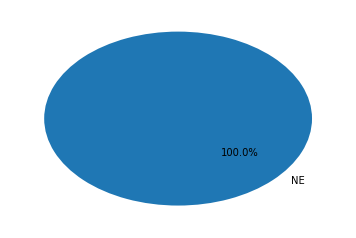

In [115]:
# Create the defaultdict: ner_categories
ner_categories = defaultdict(int)

# Tokenize the article into sentences: sentences
sentences = sent_tokenize(str_tweet)

# Tokenize each sentence into words: token_sentences
token_sentences = [word_tokenize(sent) for sent in sentences]

# Tag each tokenized sentence into parts of speech: pos_sentences
pos_sentences = [pos_tag(sent) for sent in token_sentences] 

# Create the named entity chunks: chunked_sentences
chunked_sentences = ne_chunk_sents(pos_sentences, binary=True)


for sent in chunked_sentences:
    for chunk in sent:
        if hasattr(chunk, "label"):
           
           ner_categories[chunk.label()] += 1

# Create a list from the dictionary keys for the chart labels: labels
labels = list(ner_categories.keys())

# Create a list of the values: values
values = [ner_categories.get(l) for l in labels]


# Create the pie chart
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)

# Display the chart
plt.show()
